In [1]:
import sys
import os

print("Current Working Directory:", os.getcwd())

# Add the examples directory to sys.path so we can import the set_random_seed function and other utilities from causal_helpers
examples_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'examples'))
sys.path.append(examples_dir)
# Now import set_random_seed directly from causal_helpers
from causal_helpers import set_random_seed

# Add the data directory to sys.path so we can save and load data files
data_dir = os.path.abspath(os.path.join(examples_dir, '..', 'data'))

# Use the function
seed = 41 # main seed
set_random_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Current Working Directory:", os.getcwd())

Current Working Directory: /home/amine.mcharrak/pcax/examples
Current Working Directory: /home/amine.mcharrak/pcax/examples


In [2]:
def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def generate_mixed_data_binary(num_samples, w_ranges=((-2.0, -0.5), (0.5, 2.0)), noise_scale=1.0, softplus=True):
    """
    Generate mixed observational data with continuous and binary variables based on a predefined causal structure.

    Arguments:
        num_samples [int]: Number of samples to generate.
        w_ranges [tuple]: Ranges for sampling linear weights.
        noise_scale [float]: Standard deviation of additive noise.

    Returns:
        adjacency_matrix [np.ndarray]: Adjacency matrix representing the causal graph.
        data [pd.DataFrame]: Generated observational data with mixed data types.
    """

    # Define the adjacency matrix in x0 to x11 order
    adjacency_matrix = np.zeros((12, 12))
    adjacency_matrix[0, 1] = 1  # x0 -> x1
    for i in [2, 3, 4]:  # Confounders
        adjacency_matrix[i, 0] = 1  # Confounder -> x0
        adjacency_matrix[i, 1] = 1  # Confounder -> x1
    for i in [5, 6]:  # Causes of x0
        adjacency_matrix[i, 0] = 1
    for i in [7, 8]:  # Causes of x1
        adjacency_matrix[i, 1] = 1
    adjacency_matrix[0, 9] = 1  # x0 -> x9
    adjacency_matrix[1, 10] = 1  # x1 -> x10
    adjacency_matrix[0, 11] = 1  # x0 -> x11
    adjacency_matrix[1, 11] = 1  # x1 -> x11

    # Generate weights for linear equations
    W = simulate_parameter(adjacency_matrix, w_ranges=w_ranges)

    # Initialize data dictionary
    data = {}

    # Generate root nodes (binary and continuous)
    data["x2"] = np.random.choice([0, 1], size=num_samples)  # binary
    data["x3"] = np.random.normal(loc=0, scale=noise_scale, size=num_samples)  # continuous
    data["x4"] = np.random.choice([0, 1], size=num_samples)  # binary
    data["x5"] = np.random.choice([0, 1], size=num_samples)  # binary
    data["x6"] = np.random.normal(loc=0, scale=noise_scale, size=num_samples)  # continuous
    data["x7"] = np.random.choice([0, 1], size=num_samples)  # binary
    data["x8"] = np.random.normal(loc=0, scale=noise_scale, size=num_samples)  # continuous

    # Helper function for linear SEM
    def simulate_linear(parent_vars, weights, noise_scale=1.0, softplus=softplus):
        noise = np.random.normal(scale=noise_scale, size=parent_vars.shape[0])
        if softplus:
            noise = np.log(1 + np.exp(noise))
        return parent_vars @ weights + noise

    # Compute child nodes using linear SEM
    parent_vars_x0 = np.column_stack([data[f"x{i}"] for i in [2, 3, 4, 5, 6]])
    x0_noise_scale = 0.0  # No noise for x0
    # TODO check which noise scale for x0 is appropriate
    #linear_combination_x0 = simulate_linear(parent_vars_x0, W[[2, 3, 4, 5, 6], 0], noise_scale)
    linear_combination_x0 = simulate_linear(parent_vars_x0, W[[2, 3, 4, 5, 6], 0], x0_noise_scale) # THIS SHOULD BE CORRECT B/C SAMPLING FOR BERNOULLI NEXT WILL INTRODUCE NOISE

    # Plot the linear combination of x0 before applying binary transformation
    plt.figure(figsize=(10, 5))
    plt.hist(linear_combination_x0, bins=50, density=True, alpha=0.6, color="blue", label="Linear Combination of x0")
    plt.xlabel("Linear Combination of x0")
    plt.ylabel("Frequency")
    plt.title("Linear Combination of x0 Before Applying Binary Transformation")
    plt.savefig("linear_combination_x0.pdf")
    plt.show()

    probabilities_x0 = (np.tanh(linear_combination_x0) + 1) / 2  # Probabilities for binary x0
    data["x0"] = np.random.binomial(1, p=probabilities_x0)

    # Plot the binary x0 after applying binary transformation
    plt.figure(figsize=(10, 5))
    plt.hist(data["x0"], bins=50, density=True, alpha=0.6, color="blue", label="Binary x0")
    plt.xlabel("Binary x0")
    plt.ylabel("Frequency")
    plt.title("Binary x0 After Applying Binary Transformation")
    plt.savefig("binary_x0.pdf")
    plt.show()

    parent_vars_x1 = np.column_stack([data[f"x{i}"] for i in [0, 2, 3, 4, 7, 8]])
    data["x1"] = simulate_linear(parent_vars_x1, W[[0, 2, 3, 4, 7, 8], 1], noise_scale)

    # Downstream variables
    data["x9"] = simulate_linear(data["x0"].reshape(-1, 1), W[[0], 9], noise_scale)
    data["x10"] = simulate_linear(data["x1"].reshape(-1, 1), W[[1], 10], noise_scale)
    parent_vars_x11 = np.column_stack([data["x0"], data["x1"]])
    data["x11"] = simulate_linear(parent_vars_x11, W[[0, 1], 11], noise_scale)

    # Convert to DataFrame and reorder columns
    data_df = pd.DataFrame(data)[[f"x{i}" for i in range(12)]]

    return W, adjacency_matrix, data_df

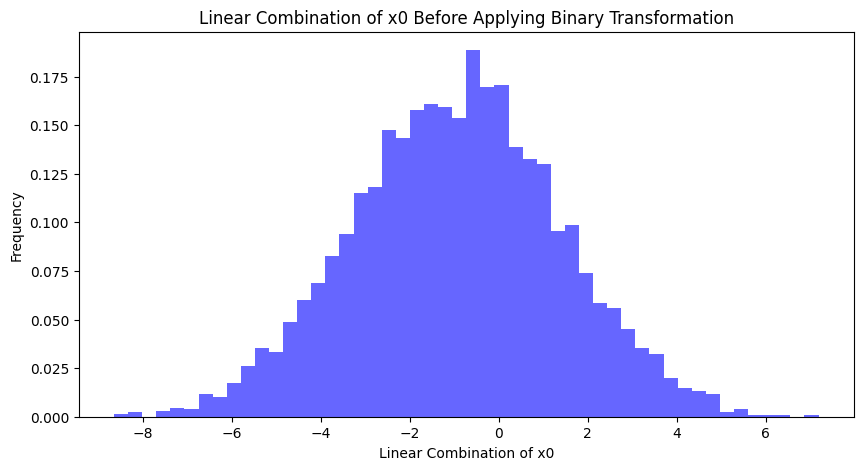

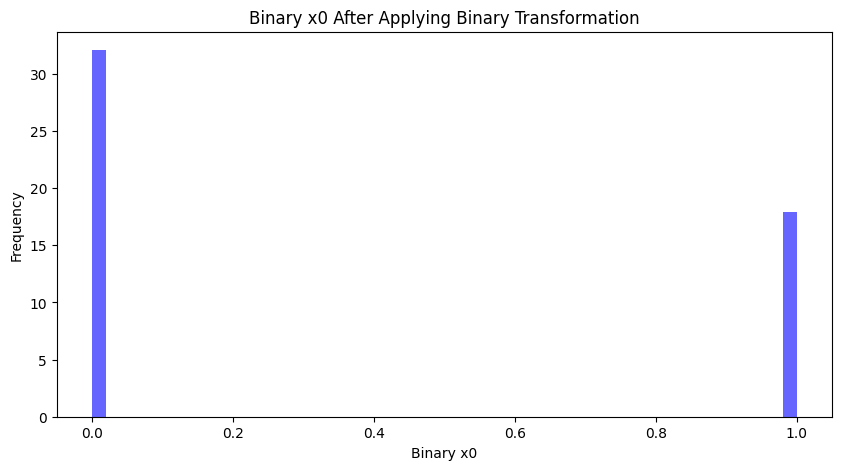

Adjacency Matrix:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Generated Data:
   x0        x1  x2        x3  x4  x5        x6  x7        x8        x9  \
0   1 -1.069775   1 -0.057767   0   1 -1.240767   0  0.977668  1.387689   
1   1  3.535039   0  0.286973   0   1  0.075509   0 -0.662300  2.116923   
2   0 -0.637272   0 -0.475930   1   1  0.812017   0 -0.590158  0.300578   
3   0 -0.392384   1  0.035141   0   0  0.608076   1 -1.805666  0.978422   
4   1 -2.213314   0 -1.479576   1   0 -0.444221   1 -1.255395  2.394487   

        x10       x11  
0 -0.709630  1.208056

In [3]:
# Example usage
num_samples = 4000
softplus = True
w_ranges=((-2.0, -1.0), (1.0, 2.0))
W, adj_matrix, data = generate_mixed_data_binary(num_samples=num_samples, w_ranges=w_ranges, softplus=softplus)

# Display the adjacency matrix and a preview of the data
print("Adjacency Matrix:")
print(adj_matrix)
print("\nGenerated Data:")
print(data.head())
print("\nTrue Weights:")
print(W)

In [4]:
dir_name = os.path.join(data_dir, "custom_mixed_confounding")

if not softplus:
    os.makedirs("custom_mixed_confounding", exist_ok=True)
else:
    dir_name += "_softplus"
    os.makedirs(dir_name, exist_ok=True)

# store the adjacency matrix as a csv file named "adj_matrix.csv" without header
adj_matrix_df = pd.DataFrame(adj_matrix)
adj_matrix_df.to_csv(f"{dir_name}/adj_matrix.csv", header=False, index=False)

# store the data as a csv file named "train.csv" without header
data.to_csv(f"{dir_name}/train.csv", header=False, index=False)

# store the weighted adjacency matrix as a csv file named "W.csv" without header
W_df = pd.DataFrame(W)
W_df.to_csv(f"{dir_name}/W_adj_matrix.csv", header=False, index=False)

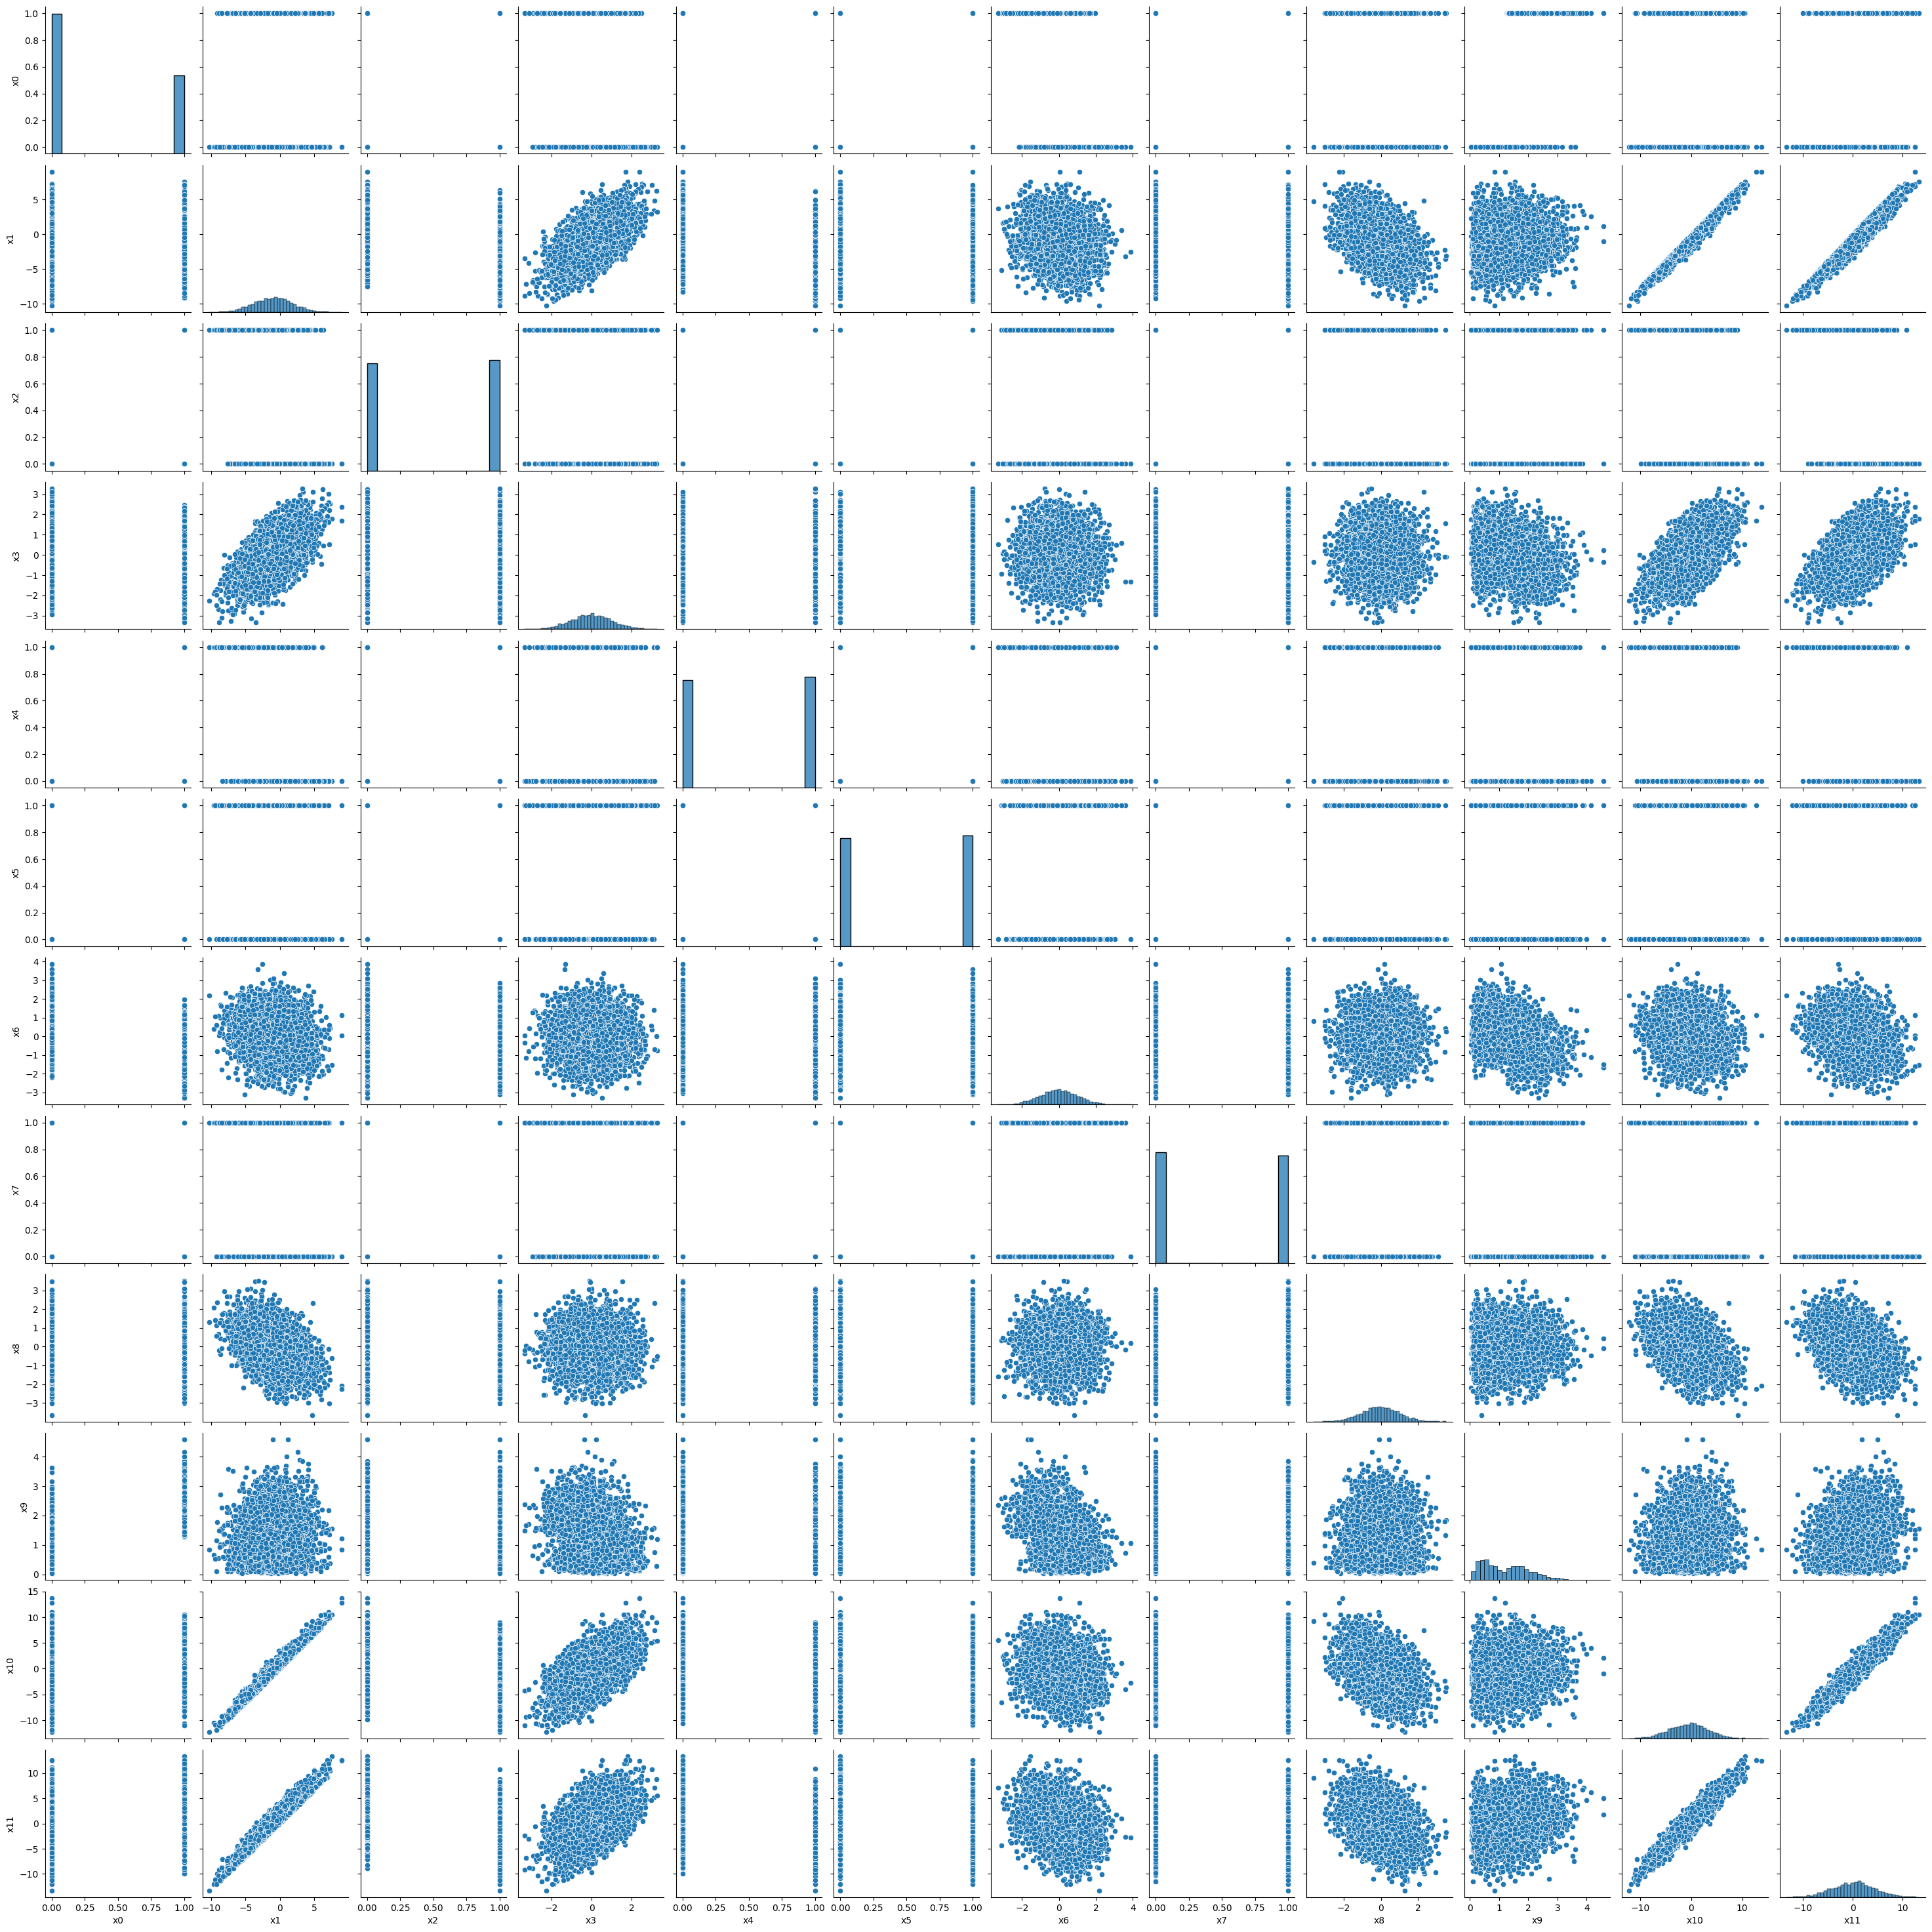

In [5]:
# plot the distribution of all variables against each other and save the plot as "pairplot.pdf"
import seaborn as sns
sns.pairplot(data)
plt.savefig(f"{dir_name}/pairplot.pdf")

In [6]:
################################## MISC ##################################